### Use the Asynchronous Advantage Actor Critic (A3C) Policy Gradient Method to solve Breakout

In [13]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import progressbar as pb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

In [2]:
env_id = 'Breakout-v0'
env = gym.make(env_id)

In [5]:
env.observation_space

Box(210, 160, 3)

In [14]:
print(f"Actions:{env.action_space}\nMeanings:{env.unwrapped.get_action_meanings()}")

Actions:Discrete(4)
Meanings:['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #convert to GPU if available

## Preprocess Image

In [45]:
## Utils
def preprocess_single_frame(image, bkg_color = np.array([144, 72, 17])):
    """
    Converts an image from RGB channel to B&W channels.
    Also performs downscale to 80x80. Performs normalization.
    @Param:
    1. image: (array_like) input image. shape = (210, 160, 3)
    2. bkg_color: (np.array) standard encoding for brown in RGB with alpha = 0.0
    @Return:
    - img: (array_like) B&W, downscaled, normalized image of shape (80x80)
    """
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

#Utils
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    """
    convert outputs of parallelEnv to inputs to pytorch neural net"""
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)

In [46]:
state = env.reset()
for _ in range(20):#skip 20 frames
    frame, _, _, _ = env.step(np.random.randint(0, env.action_space.n))

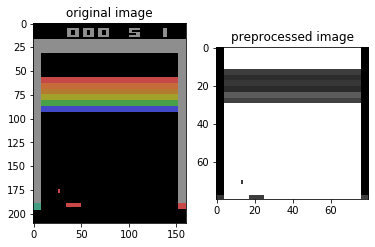

In [47]:
#Plot processed and raw image
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')
# 80 x 80 black and white image
plt.imshow(preprocess_single_frame(frame), cmap='Greys')
plt.show()

# Actor-Critic

<img height=500 width=500 src="https://www.mdpi.com/energies/energies-09-00725/article_deploy/html/images/energies-09-00725-g001-1024.png">

In [ ]:
class Actor(nn.Module):
    def __init__(self, action_size=4):
        super(Actor, self).__init__(self)
        self.action_size = action_size
        
        #Define the CNN
        